# 과제#1. 더반찬 주문량 예측

* 비지니스 상황
    * 반찬 판매량 예측을 통한 페기비용 및 기회상실 비용 절감
    * 오더 시점의 주문량이 타겟이 아니라 희망배송일의 주문량이 타겟이 됨
    * 예측 범위: 월~토(주간 예측모델): 매주 일요일 혹은 월요일 새벽에 가동된다는 가정
    * 모델 평가기간 2022-06-01 ~ 2022-06-30
    * 평가지표 R2, RMSE, 예측 정확도(abs(예측-실제)/실제)

&nbsp;
* 주의사항: Regression 사용시 미래에도 독립변수로 활용할 수 있는 인자를 사용해야함
           (예를 들어, 할인 판매 금액데이터는 미래 일주일 치를 받을 수 없음)

|	필드이름	|	유형	|	설명	|
|	----	|	----	|	----	|
|	ORD_NO 	|	STRING	|	order 시리얼 넘버	|   
|	H_YMD 	|	STRING	|	희망배송일	|  
|	O_YMD 	|	STRING	|	오더 시간	|  
|	PKG_GOODS_NO 	|	STRING	|	단품인지 세트인지 구성상품	|   
|	PKG_GOODS_NM 	|	STRING	|	단품인지 세트인지 구성상품	|   
|	GOODS_NO 	|	STRING	|	자재코드	|   
|	GOODS_NM 	|	STRING	|	자재명	|   
|	STD_GSGR_NO_LEV1_NM 	|	 STRING	|	자재 카테고리	|   
|	ORD_QTY 	|	 INTEGER	|	오더건수	|   
|	CANCEL_QTY 	|	 INTEGER	|	취소 오더건수	|   
|	RET_QTY 	|	 INTEGER	|	환불 오더건수	|   
|	REAL_ORD_QTY 	|	 INTEGER	|	최종 오더건수	|   
|	RECVR_ROAD_BASE_ADDR 	|	 STRING	|	주소	|   
|	SALE_PRICE 	|	 INTEGER	|	판매가격	|   
|	DISCOUNT_AMT	|	 INTEGER	|	할인액  |   
|	FINAL-PRICE 	|	 INTEGER	|	최종 판매 가격	|   

## 가설


1. 가격이 낮을수록 판매량이 많을 것이다.
2. 할인액이 높을수록 판매량이 많을 것이다.
3. 계절별로 판매되는 제품의 수가 다를 것이다.
4. 고단백 식품이 여름에 더 많이 팔릴 것이다.
5. 명절에 명절음식 뿐 아니라 다른 음식도 판매량이 늘 것이다.
6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)
7. 카테고리별로 판매량이 다를 것이다.
8. 배달 주소건수 비율이 높은 지역은 취소나 환불이 적을 것이다.
9. 주문하는 시간대는 주로 퇴근시간대나 그 이후일 것이다.
10. 재철재료가 들어간 식품은 그 계절에 잘 팔릴 것이다.
11. 2022.06.02 대장균 검출 기사가 난 이후 판매량이 줄었을 것이다.
12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
13. 주 고객층은 자녀를 둔 부모나 혼자사는 사람일 것이다.

In [48]:
# 1. 가격이 낮을수록 판매량이 많을 것이다.
# 2. 할인액이 높을수록 판매량이 많을 것이다.
# 3. 계절별로 판매되는 제품의 수가 다를 것이다.
# 4. 고단백 식품이 여름에 더 많이 팔릴 것이다.
# 5. 명절에 명절음식 뿐 아니라 다른 음식도 판매량이 늘 것이다.
# 6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)
# 7. 카테고리별로 판매량이 다를 것이다.
# 8. 배달 주소건수 비율이 높은 지역은 취소나 환불이 적을 것이다.
# 9. 주문하는 시간대는 주로 퇴근시간대나 그 이후일 것이다.
# 10. 재철재료가 들어간 식품은 그 계절에 잘 팔릴 것이다.
# 11. 2022.06.02 대장균 검출 기사가 난 이후 판매량이 줄었을 것이다.
# 12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
# 13. 주 고객층은 자녀를 둔 부모나 혼자사는 사람일 것이다.

## 0. 환경준비

### 0.1 Import

In [1]:
# 기본 라이브러리 가져오기
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  

### 0.2 Data Loading

In [5]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\Users\user\Desktop\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.0,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.0,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.0,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.0,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.0,6743


In [35]:
# 카피 데이터 생성
copy_data = raw_data.copy()

copy_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.0,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.0,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.0,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.0,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.0,6743


## 1. 데이터 탐색

### 1.1 데이터 확인

In [20]:
# 데이터의 정보 확인
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724702 entries, 0 to 724701
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            724702 non-null  int64  
 1   ORD_NO                724702 non-null  int64  
 2   H_YMD                 724702 non-null  object 
 3   O_YMD                 724702 non-null  object 
 4   PKG_GOODS_NO          724702 non-null  object 
 5   PKG_GOODS_NM          724702 non-null  object 
 6   GOODS_NO              724702 non-null  int64  
 7   GOODS_NM              724702 non-null  object 
 8   STD_GSGR_NO_LEV1_NM   724702 non-null  object 
 9   ORD_QTY               724702 non-null  int64  
 10  CANCEL_QTY            724702 non-null  int64  
 11  RET_QTY               724702 non-null  int64  
 12  REAL_ORD_QTY          724702 non-null  int64  
 13  RECVR_ROAD_BASE_ADDR  724702 non-null  object 
 14  SALE_PRICE            724702 non-null  int64  
 15  

In [21]:
# 결측치 확인 -> DISCOUNT_AMT변수에서 376247개의 결측치 확인
# 결측치라기 보다는 할인액이 없는, 할인되지 않은 상품으로 예상되어 0으로 대체해도 될 것 같음
copy_data.isna().sum()

Unnamed: 0                   0
ORD_NO                       0
H_YMD                        0
O_YMD                        0
PKG_GOODS_NO                 0
PKG_GOODS_NM                 0
GOODS_NO                     0
GOODS_NM                     0
STD_GSGR_NO_LEV1_NM          0
ORD_QTY                      0
CANCEL_QTY                   0
RET_QTY                      0
REAL_ORD_QTY                 0
RECVR_ROAD_BASE_ADDR         0
SALE_PRICE                   0
DISCOUNT_AMT            376247
FINAL_PRICE                  0
dtype: int64

In [22]:
#PKG_GOODS_NO 정보 확인 -> 단품외에 상품이 존재
### 단품 상품이 아닌 경우 코드가 어떤 제품을 나타내는지 알아볼 필요가 있음
copy_data['PKG_GOODS_NO'].value_counts()

단품            661716
2106015591      6049
2107015727      5599
2103015234      4837
2107015647      3474
               ...  
2205016968        11
2202016453         8
2106015460         5
2202016409         3
1908013238         2
Name: PKG_GOODS_NO, Length: 77, dtype: int64

In [23]:
# PKG_GOODS_NM 정보 확인 -> 골라담기, 내일한정, 한정판매, 신규, 세트 등이 있음
### 내일한정 같은 경우는 단품으로 분류해야 하지 않을까?
copy_data['PKG_GOODS_NM'].value_counts()

단품                                        661716
더반찬& 인기 시그니처 2종 골라담기 (5,000원 부터~)           9540
더반찬& 집밥만찬 2종 골라담기 (5,000원 부터~)              5599
[심방골주부X더반찬] 한식밥상 2종 골라담기 (16,660원 부터~)      4837
[내일한정] 두메산나물비빔밥재료                           3099
                                           ...  
[한정판매]베스트셀러 2종 set                            21
신규.싱글세트18-1                                   16
신규.패밀리세트8-2                                   11
[한정판매]키즈 set                                   8
[내일한정] 꼬막무침 (250g)                             5
Name: PKG_GOODS_NM, Length: 72, dtype: int64

In [388]:
#GOODS_NO정보 확인
copy_data['GOODS_NO'].value_counts()
copy_data['GOODS_NO'].value_counts().sum()

724702

In [24]:
#GOODS_NM 정보 확인
copy_data['GOODS_NM'].value_counts()
#copy_data['GOODS_NM'].value_counts().sum()

두메산나물비빔밥재료                    159184
옛날잡채(500g)                    112852
셀프두부조림(600g)                   48948
숙주나물(300g)                     43906
채소계란찜(340g)                    38440
한돈 제육볶음(700g)                  35142
수제계란말이(350g)                   33080
건표고버섯볶음                        29162
꼬막무침 (250g)                    26499
양장피                            25901
가정집 오징어불고기/셀프(380g)            24389
고소한도토리묵무침(265g)                21898
건고사리나물볶음(150g)                 17556
[심방골주부X더반찬] 시골 돼지짜글이(600g)     17382
고구마 품은 라자냐(450g)               16660
우삼겹숙주볶음(250g)                  15293
순살코다리강정(180g)                  14526
메밀소바(2인분)                      13860
열무비빔밥재료믹스(2인분)                  9915
꼬막무침 (260g)                     9284
고소한도토리묵무침(360g)                 4744
고사리나물볶음(150g)                   4182
소고기유니짜장소스(1인분, 200g)            1899
Name: GOODS_NM, dtype: int64

In [25]:
#STD_GSGR_NO_LEV1_NM wjdqh 정보 확인
copy_data['STD_GSGR_NO_LEV1_NM'].value_counts()

메인요리    362212
반찬      358623
국         3867
Name: STD_GSGR_NO_LEV1_NM, dtype: int64

### 1.2 데이터 보완하기

a) PKG_GOODS_NM의 데이터를 단품 or 세트로 대체해주는 작업 실시

In [391]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {'171201310' : '두메산나물비빔밥재료', '14375':	'옛날잡채(500g)', '3273':'채소계란찜(340g)', '13957':'셀프두부조림(600g)', '1901012353':'수제계란말이(350g)',
             '13529':'메밀소바(2인분)', '1803010879':'고소한도토리묵무침(265g)', '2012014895':'한돈 제육볶음(700g)', '2204016772':'소고기유니짜장소스(1인분, 200g)', 
             '1823':'숙주나물(300g)', '4092':'건표고버섯볶음', '14985':'양장피', '1808011751':'꼬막무침 (250g)', '1903012675':'순살코다리강정(180g)', 
             '2010014667':'우삼겹숙주볶음(250g)', '1806011271':'열무비빔밥재료믹스(2인분)', '2103015231':'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             '2010014707':'고구마 품은 라자냐(450g)', '1805011121':'건고사리나물볶음(150g)', '1909013359':'가정집 오징어불고기/셀프(380g)'
             }

In [26]:
GOODS_NM_dic = []

for i in copy_data['PKG_GOODS_NM']:
    if i not in GOODS_NM_dic:
        GOODS_NM_dic.append(i)

print(GOODS_NM_dic)

['단품', '[내일한정] 수제계란말이(350g)', '메밀소바+돈까스 SET', '[내일한정] 메밀소바(2인분)', '[특판] 웰스토리 전자레인지 조리세트', '잔치상 세트', '[심방골주부X더반찬] 한식밥상 2종 골라담기 (16,660원 부터~)', 'SK스토아 베스트 세트', '[내일한정] 셀프두부조림(600g)', '[내일한정] 숙주나물(300g)', '[내일한정] 고소한도토리묵무침(265g)', '[내일한정] 옛날잡채(500g)', '[내일한정] 한돈 제육볶음(700g)', '[내일한정] [심방골주부X더반찬] 시골 돼지짜글이(600g)', '[내일한정] 고구마 품은 라자냐(450g)', '[내일한정] 양장피', '[내일한정] 두메산나물비빔밥재료', '[내일한정] 가정집 오징어불고기/셀프(380g)', '[내일한정] 채소계란찜(340g)', '[내일한정] 우삼겹숙주볶음(250g)', '[내일한정] 순살코다리강정(180g)', '[내일한정] 건고사리나물볶음(150g)', '[내일한정] 건표고버섯볶음', '더반찬& 집밥만찬 2종 골라담기 (5,000원 부터~)', '한돈제육세트', '더반찬& 메인메뉴 1종 + 내맘대로 2종 골라담기(15,900원부터~)', '더반찬& 고메위크 골라담기', '열무비빔밥+된찌 SET', '저녁을 부탁해 세트 A', '더반찬& 인기 밑반찬 3종 골라담기 (7,500원 부터~)', '더반찬& 인기 시그니처 2종 골라담기 (5,000원 부터~)', '[내일한정] 열무비빔밥재료믹스(2인분)', '[내일한정] 꼬막무침 (250g)', '더반찬 베스트 C세트', '짭쪼름한 안주세트', '[한정판매] 두메산나물비빔밥재료', '[한정판매] 옛날잡채(500g)', '[더반찬] 주말 밥상세트 A', '[설날] 더반찬 프리미엄 차례상 (사용X)', '저녁을 부탁해 세트 B', '[내일한정] 꼬막무침 (260g)', '[내일한정] 고사리나물볶음(150g)', '[한정판매]손님초대상 set', '[한정판매]반찬 한 상 set', '[한정판매]키즈 s

In [36]:
# 내일한정, 한정판매는 단품으로 대체
# 한정판매 중에는 단품이 아닌 세트도 있어서 이를 유의해야 함(ex. '[한정판매]손님초대상 set', '[한정판매]반찬 한 상 set', '[한정판매]키즈 set')

# 내일한정이 붙은 제품은 모두 단품인 것을 확인하여 카테고리를 단품으로 바꿔줌
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'].str.contains('내일한정')] = '단품'

# 한정판매 중에서 두 제품만 단품이었기에 두 제품을 단품으로 바꿔줌
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] == '[한정판매] 두메산나물비빔밥재료'] = '단품'  
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] == '[한정판매] 옛날잡채(500g)'] = '단품'

# 단품으로 바꿔주지 않은 모든 제품을 세트로 바꿔줌
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] != '단품'] = '세트'

C:\Users\user\AppData\Local\Temp\ipykernel_4584\916191488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'].str.contains('내일한정')] = '단품'
C:\Users\user\AppData\Local\Temp\ipykernel_4584\916191488.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] == '[한정판매] 두메산나물비빔밥재료'] = '단품'
C:\Users\user\AppData\Local\Temp\ipykernel_4584\916191488.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [28]:
GOODS_NM_dic = []

for i in copy_data['PKG_GOODS_NM']:
    if i not in GOODS_NM_dic:
        GOODS_NM_dic.append(i)

print(GOODS_NM_dic)

['단품', '세트']


b) 지역 이름 전처리

In [37]:
# 각 지역의 이름이 들어간 경우 해당 시나 도의 이름을 바꾸어준다.

copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('서울')] = '서울시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Seoul')] = '서울시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('인천')] = '인천시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Incheon')] = '인천시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('부산')] = '부산시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Busan')] = '부산시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('대구')] = '대구시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Daegu')] = '대구시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('광주')] = '광주시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('대전')] = '대전시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Daejeon')] = '대전시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('울산')] = '울산시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('세종')] = '세종시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('용인')] = '용인시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('고양')] = '고양시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('수원')] = '수원시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('성남')] = '성남시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('화성')] = '화성시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('평택')] = '평택시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('하남')] = '하남시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('부천')] = '부천시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('오산')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('안산')] = '안산시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('군포')] = '군포시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('안성')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('구리')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('파주')] = '파주시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('광명')] = '광명시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('과천')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('포천')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('남양주')] = '남양주시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('의정부')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('시흥')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('연천')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('여주')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('의왕')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('안양')] = '안양시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('김포')] = '김포시'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('이천')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('경기')] = '경기도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Gyeonggi')] = '경기도'

copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('강원')] = '강원도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Chungcheongnam-do')] = '충청남도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('충청남도')] = '충청남도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('충남')] = '충청남도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('충청북도')] = '충청북도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('충북')] = '충청북도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Chungcheongbuk-do')] = '충청북도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('전라남도')] = '전라남도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('전남')] = '전라남도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Jeollanam-do')] = '전라남도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('전라북도')] = '전라북도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('전북')] = '전라북도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Jeollabuk-do')] = '전라북도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('경상남도')] = '경상남도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('경남')] = '경상남도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('경상북도')] = '경상북도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('경북')] = '경상북도'
copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('제주')] = '제주시'

C:\Users\user\AppData\Local\Temp\ipykernel_4584\302568830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('서울')] = '서울시'
C:\Users\user\AppData\Local\Temp\ipykernel_4584\302568830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_data['RECVR_ROAD_BASE_ADDR'].loc[copy_data['RECVR_ROAD_BASE_ADDR'].str.contains('Seoul')] = '서울시'
C:\Users\user\AppData\Local\Temp\ipykernel_4584\302568830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [38]:
copy_data['RECVR_ROAD_BASE_ADDR'].value_counts()

서울시                  260197
인천시                   44932
경기도                   37897
부산시                   30097
용인시                   28781
수원시                   24538
고양시                   23035
성남시                   21537
경상남도                  19588
충청남도                  18045
대구시                   16712
경상북도                  16306
강원도                   15313
화성시                   15199
광주시                   14864
대전시                   13538
충청북도                  13101
부천시                   12383
안양시                   10947
전라북도                  10866
전라남도                  10571
김포시                    8707
안산시                    8072
남양주시                   7981
광명시                    6901
평택시                    6844
울산시                    6228
파주시                    5935
군포시                    5363
세종시                    5114
하남시                    5093
제주시                       8
농서로84 삼성전자 남자기숙사          3
5, To                     2
동탄 하나 1길                  1
비전2로2               

In [39]:
# 위 과정을 거치고도 남은 데이터와 잘못 적재 된 데이터들은 NaN값으로 바꾸어준다.
# 해당 결측치는 추우 KNN Imputer나 다른 방법으로 메꿀 예정이다. 

area = ['서울시','인천시','부산시','대구시','광주시','대전시','울산시','세종시','용인시','고양시','수원시', '강원도',
        '성남시','화성시','평택시','하남시','부천시','안산시','군포시', '파주시', '광명시', '남양주시', '안양시', 
        '김포시','경기도','충청남도','충청북도','전라남도','전라북도','경상남도','경상북도','제주시']

copy_data['RECVR_ROAD_BASE_ADDR'].loc[~copy_data['RECVR_ROAD_BASE_ADDR'].isin(area)] = np.nan

C:\Users\user\AppData\Local\Temp\ipykernel_4584\3260748512.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_data['RECVR_ROAD_BASE_ADDR'].loc[~copy_data['RECVR_ROAD_BASE_ADDR'].isin(area)] = np.nan


In [40]:
copy_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도,6900,569.0,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울시,6900,177.0,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울시,6900,221.0,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도,6900,128.0,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,용인시,6900,157.0,6743


In [41]:
# 원하는 지역별로 잘 나누어진 모습이다.
copy_data['RECVR_ROAD_BASE_ADDR'].value_counts()

서울시     260197
인천시      44932
경기도      37897
부산시      30097
용인시      28781
수원시      24538
고양시      23035
성남시      21537
경상남도     19588
충청남도     18045
대구시      16712
경상북도     16306
강원도      15313
화성시      15199
광주시      14864
대전시      13538
충청북도     13101
부천시      12383
안양시      10947
전라북도     10866
전라남도     10571
김포시       8707
안산시       8072
남양주시      7981
광명시       6901
평택시       6844
울산시       6228
파주시       5935
군포시       5363
세종시       5114
하남시       5093
제주시          8
Name: RECVR_ROAD_BASE_ADDR, dtype: int64

In [42]:
# 약 10개 가량의 결측치가 생겼다.
# 이는 추후에 KNN imputer나 다른 방식으로 채워줄 예정이다.
copy_data['RECVR_ROAD_BASE_ADDR'].isna().sum()

9

c) 불필요한 컬럼 제거

In [43]:
copy_data.columns 

Index(['Unnamed: 0', 'ORD_NO', 'H_YMD', 'O_YMD', 'PKG_GOODS_NO',
       'PKG_GOODS_NM', 'GOODS_NO', 'GOODS_NM', 'STD_GSGR_NO_LEV1_NM',
       'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY',
       'RECVR_ROAD_BASE_ADDR', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE'],
      dtype='object')

In [44]:
dummy_col = ['Unnamed: 0', 'ORD_NO', 'PKG_GOODS_NO']
copy_data = copy_data.drop(dummy_col, axis=1)

In [49]:
copy_data.tail()

,H_YMD,O_YMD,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
724697,2020-03-12 00:00:00,2020-03-05 00:50:32,단품,14375,옛날잡채(500g),메인요리,9,0,0,9,안산시,8600,NaN,8600
724698,2020-03-09 00:00:00,2020-03-06 11:38:04,단품,1909013359,가정집 오징어불고기/셀프(380g),반찬,16,0,0,16,서울시,9900,464.0,9436
724699,2020-03-23 00:00:00,2020-03-20 20:04:27,단품,1909013359,가정집 오징어불고기/셀프(380g),반찬,16,0,0,16,서울시,9900,NaN,9900
724700,2020-03-26 00:00:00,2020-03-23 19:20:15,단품,14375,옛날잡채(500g),메인요리,20,0,0,20,서울시,8600,NaN,8600
724701,2020-03-30 00:00:00,2020-03-27 15:04:00,단품,14375,옛날잡채(500g),메인요리,30,0,0,30,서울시,8600,NaN,8600


In [46]:
# 데이터 상관관계 분석
copy_data.corr()

,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
GOODS_NO,1.000000,0.009102,-0.012331,0.004310,0.015689,0.316799,0.202943,0.237327
ORD_QTY,0.009102,1.000000,0.206051,0.022218,0.826752,0.018099,0.140279,0.000686
CANCEL_QTY,-0.012331,0.206051,1.000000,-0.009708,-0.380136,-0.010178,0.032517,-0.022129
RET_QTY,0.004310,0.022218,-0.009708,1.000000,0.026582,0.003935,0.014294,-0.000072
REAL_ORD_QTY,0.015689,0.826752,-0.380136,0.026582,1.000000,0.022960,0.098884,0.013371
SALE_PRICE,0.316799,0.018099,-0.010178,0.003935,0.022960,1.000000,0.462131,0.830052
DISCOUNT_AMT,0.202943,0.140279,0.032517,0.014294,0.098884,0.462131,1.000000,-0.284285
FINAL_PRICE,0.237327,0.000686,-0.022129,-0.000072,0.013371,0.830052,-0.284285,1.000000


<AxesSubplot:>

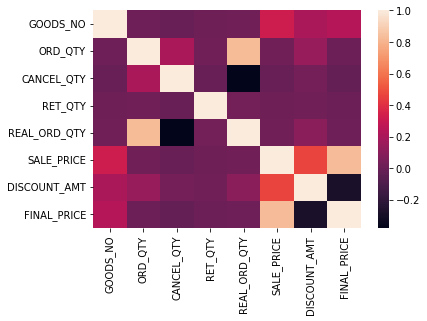

In [47]:
sns.heatmap(copy_data.corr())

### 1.3 단변량 분석

In [ ]:
# 1. 가격이 낮을수록 판매량이 많을 것이다.
# 2. 할인액이 높을수록 판매량이 많을 것이다.
# 3. 계절별로 판매되는 제품의 수가 다를 것이다.
# 4. 고단백 식품이 여름에 더 많이 팔릴 것이다.
# 5. 명절에 명절음식 뿐 아니라 다른 음식도 판매량이 늘 것이다.
# 6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)
# 7. 카테고리별로 판매량이 다를 것이다.
# 8. 배달 주소건수 비율이 높은 지역은 취소나 환불이 적을 것이다.
# 9. 주문하는 시간대는 주로 퇴근시간대나 그 이후일 것이다.
# 10. 재철재료가 들어간 식품은 그 계절에 잘 팔릴 것이다.
# 11. 2022.06.02 대장균 검출 기사가 난 이후 판매량이 줄었을 것이다.
# 12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
# 13. 주 고객층은 자녀를 둔 부모나 혼자사는 사람일 것이다.

In [ ]:
for i in copy_data['H_YMD']:
    print(i)

ValueError: could not convert string to float: '2022-01-11 00:00:00'

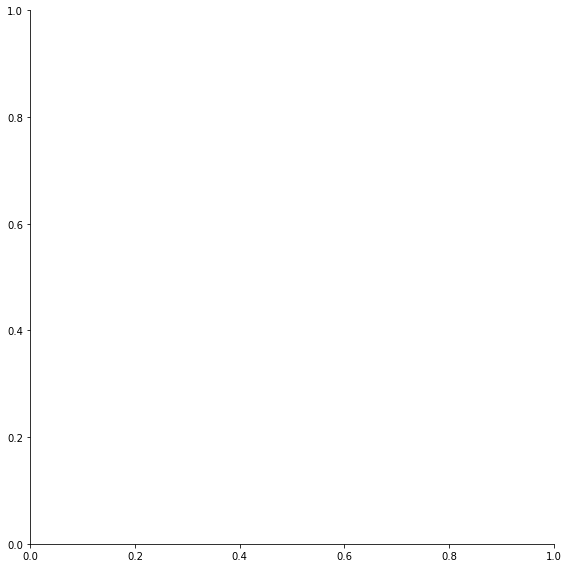

In [52]:
# 3. 계절별로 판매되는 제품의 수가 다를 것이다.
sns.lmplot(x="H_YMD", y="REAL_ORD_QTY", height=8, data=copy_data)
plt.show()

### 1.4 이변량 분석

## 2. 데이터 전처리

### 2.1 target, feature 분리

### 2.2 NaN 결측치 처리

### 2.3 가변수화

### 2.4 추가 옵션 도출(feature Engineering)

### 2.5 데이터 분할

### 2.6 스케일링

## 3. 모델링

### 3.1 머신러닝 모델 3개

### 3.2 딥러닝 모델

## 4. 성능 비교

## 5. 비지니스 인사이트 도출